## API KEY Setting

In [1]:
import os
from config.secret_key import OPENAI_API_KEY, TAVILY_API_KEY, POLYGON_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['POLYGON_API_KEY'] = POLYGON_API_KEY

## Import Modules

In [2]:
import pandas as pd
import yfinance as yf
from polygon import RESTClient # polygon-api-client 모듈 설치 필요요
from langchain.agents.agent_types import AgentType # create_pandas_dataframe_agent 의 매개변수로 필요요
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_core.tools import tool
from pathlib import Path
from langchain_openai import ChatOpenAI
# from dotenv import load_dotenv
# load_dotenv()

os.getcwd()

'c:\\finpilot'

## Directory Setting

In [4]:
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data' # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / 'charts' # 차트 저장용 디엑토리

## `yfinance`, `Polygon` API로 자사, 경쟁사 주식정보 가져오기

In [5]:
polygon_client = RESTClient(api_key=os.environ["POLYGON_API_KEY"])

In [26]:
@tool
def fetch_stock_data(ticker:str, start_date:str, end_date:str):
    """
    Fetch stock data and compare with NASDAQ and competitors.
    """

    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
    nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False)
    
    df = pd.DataFrame(index=stock.index)
    df[f'{ticker}'] = stock['Close']
    df['Nasdaq'] = nasdaq['Close']

    related_companies = polygon_client.get_related_companies(ticker)
    competitors = [company.ticker for company in related_companies]

    for company in competitors:
        try:
            comp_ticker = company.replace('.', '-') if '.' in company else company
            comp_data = yf.download(comp_ticker, start=start_date, end=end_date, progress=False)
            if not comp_data.empty:
                df[company] = comp_data['Close']
        except Exception as e:
            continue
    
    csv_path = DATA_DIR / "stock_data.csv"
    df.to_csv(csv_path)

    return f"Stockfile saved to {csv_path}"

In [27]:
fetch_stock_data.run({"ticker" : "NVDA",
                      "start_date" : "2023-01-01",
                      "end_date" : "2024-01-01"})

'Stockfile saved to c:\\finpilot\\data\\stock_data.csv'

## Polygon API로 재무정보 가져오기

In [6]:
@tool
def get_financial_data(ticker: str, num_years: int):
    """
    주어진 티커의 재무 데이터를 가져와 DataFrame으로 저장하고 파일 경로를 반환합니다.
    
    Parameters:
    ticker (str): 종목 코드
    num_years (int): 가져올 연도 수
    
    Returns:
    str: 저장된 파일 경로 메시지
    """
    # Polygon REST API Client 설정
    client = polygon_client
    
    # 최근 n개년간 분기별 재무제표 데이터 수집
    financials = []
    for f in client.vx.list_stock_financials(ticker):
        if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - num_years}-01-01":
            financials.append(f)
    
    # DataFrame 생성할 데이터 목록 초기화
    data = {
        # 기본 정보
        "Fiscal Year": [],
        "Fiscal Period": [],
        "End Date": [],
        
        # 손익계산서 항목
        "Revenues": [],
        "Cost of Revenue": [],
        "Gross Profit": [],
        "Operating Income": [],
        "Operating Expenses": [],
        "Basic EPS": [],
        
        # 재무상태표 항목
        "Total Assets": [],
        "Current Assets": [],
        "Fixed Assets": [],
        "Intangible Assets": [],
        "Other Current Assets": [],
        "Other Non-current Assets": [],
        "Total Liabilities": [],
        "Current Liabilities": [],
        "Non-current Liabilities": [],
        "Long Term Debt": [],
        "Total Equity": [],
        "Inventory": [],
        "Accounts Payable": [],
        "Other Current Liabilities": [],
        
        # 현금흐름표 항목
        "Net Cash Flow": [],
        "Financing Cash Flow": [],
        
        # 포괄손익 항목
        "Comprehensive Income": [],
        "Other Comprehensive Income": [],
        
        # 성장률
        "YoY Growth": [],
        "QoQ Growth": [],
        
        # 재무비율
        "Current Ratio": [],  # 유동비율
        "Debt to Equity Ratio": [],  # 부채비율
        "Gross Profit Margin": [],  # 매출총이익률
        "Operating Margin": [],  # 영업이익률
        "Asset Turnover": []  # 총자산회전율
    }
    
    # 각 재무제표 항목에서 지표들을 추출하여 DataFrame 구성
    for i, f in enumerate(financials):
        # 기본 정보
        data["Fiscal Year"].append(f.fiscal_year)
        data["Fiscal Period"].append(f.fiscal_period)
        data["End Date"].append(f.end_date)

        # 재무제표 데이터 접근
        bs = f.financials.balance_sheet
        is_ = f.financials.income_statement
        cf = f.financials.cash_flow_statement
        ci = f.financials.comprehensive_income

        # 손익계산서 데이터 추출
        revenue = getattr(is_.revenues, 'value', None) if hasattr(is_, 'revenues') else None
        data["Revenues"].append(revenue)
        data["Cost of Revenue"].append(getattr(is_.cost_of_revenue, 'value', None) if hasattr(is_, 'cost_of_revenue') else None)
        data["Gross Profit"].append(getattr(is_.gross_profit, 'value', None) if hasattr(is_, 'gross_profit') else None)
        data["Operating Expenses"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Operating Income"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Basic EPS"].append(getattr(is_.basic_earnings_per_share, 'value', None) if hasattr(is_, 'basic_earnings_per_share') else None)
        
        # 재무상태표 데이터 추출
        data["Total Assets"].append(bs['assets'].value if 'assets' in bs else None)
        data["Current Assets"].append(bs['current_assets'].value if 'current_assets' in bs else None)
        data["Fixed Assets"].append(bs['fixed_assets'].value if 'fixed_assets' in bs else None)
        data["Intangible Assets"].append(bs['intangible_assets'].value if 'intangible_assets' in bs else None)
        data["Other Current Assets"].append(bs['other_current_assets'].value if 'other_current_assets' in bs else None)
        data["Other Non-current Assets"].append(bs['other_noncurrent_assets'].value if 'other_noncurrent_assets' in bs else None)
        data["Total Liabilities"].append(bs['liabilities'].value if 'liabilities' in bs else None)
        data["Current Liabilities"].append(bs['current_liabilities'].value if 'current_liabilities' in bs else None)
        data["Non-current Liabilities"].append(bs['noncurrent_liabilities'].value if 'noncurrent_liabilities' in bs else None)
        data["Long Term Debt"].append(bs['long_term_debt'].value if 'long_term_debt' in bs else None)
        data["Total Equity"].append(bs['equity'].value if 'equity' in bs else None)
        data["Inventory"].append(bs['inventory'].value if 'inventory' in bs else None)
        data["Accounts Payable"].append(bs['accounts_payable'].value if 'accounts_payable' in bs else None)
        data["Other Current Liabilities"].append(bs['other_current_liabilities'].value if 'other_current_liabilities' in bs else None)
        
        # 현금흐름표 데이터 추출
        data["Net Cash Flow"].append(getattr(cf.net_cash_flow, 'value', None) if hasattr(cf, 'net_cash_flow') else None)
        data["Financing Cash Flow"].append(getattr(cf.net_cash_flow_from_financing_activities, 'value', None) 
                                        if hasattr(cf, 'net_cash_flow_from_financing_activities') else None)
        
        # 포괄손익 데이터 추출
        if hasattr(ci, 'comprehensive_income_loss'):
            comp_income = ci.comprehensive_income_loss.value
        else:
            comp_income = ci.comprehensive_income.value if hasattr(ci, 'comprehensive_income') else None
        data["Comprehensive Income"].append(comp_income)
        data["Other Comprehensive Income"].append(getattr(ci.other_comprehensive_income_loss, 'value', None) 
                                                if hasattr(ci, 'other_comprehensive_income_loss') else None)
        
        # YoY 성장률 계산 (전년 동기 대비)
        if i > 3 and data["Revenues"][i-4] is not None and revenue is not None:
            yoy_growth = ((revenue - data["Revenues"][i-4]) / data["Revenues"][i-4]) * 100
        else:
            yoy_growth = None
        data["YoY Growth"].append(yoy_growth)
        
        # QoQ 성장률 계산 (직전 분기 대비)
        if i > 0 and data["Revenues"][i-1] is not None and revenue is not None:
            qoq_growth = ((revenue - data["Revenues"][i-1]) / data["Revenues"][i-1]) * 100
        else:
            qoq_growth = None
        data["QoQ Growth"].append(qoq_growth)
        
        # 재무비율 계산
        current_assets = bs['current_assets'].value if 'current_assets' in bs else None
        current_liabilities = bs['current_liabilities'].value if 'current_liabilities' in bs else None
        total_liabilities = bs['liabilities'].value if 'liabilities' in bs else None
        total_equity = bs['equity'].value if 'equity' in bs else None
        total_assets = bs['assets'].value if 'assets' in bs else None
        gross_profit = getattr(is_.gross_profit, 'value', None) if hasattr(is_, 'gross_profit') else None
        operating_income = getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None
        
        # 유동비율 계산
        current_ratio = (current_assets / current_liabilities * 100) if (current_assets and current_liabilities) else None
        data["Current Ratio"].append(current_ratio)
        
        # 부채비율 계산
        debt_equity_ratio = (total_liabilities / total_equity * 100) if (total_liabilities and total_equity) else None
        data["Debt to Equity Ratio"].append(debt_equity_ratio)
        
        # 매출총이익률 계산
        gross_margin = (gross_profit / revenue * 100) if (gross_profit and revenue) else None
        data["Gross Profit Margin"].append(gross_margin)
        
        # 영업이익률 계산
        operating_margin = (operating_income / revenue * 100) if (operating_income and revenue) else None
        data["Operating Margin"].append(operating_margin)
        
        # 총자산회전율 계산
        asset_turnover = (revenue / total_assets) if (revenue and total_assets) else None
        data["Asset Turnover"].append(asset_turnover)

    # DataFrame 생성 및 정렬
    df = pd.DataFrame(data)
    df.sort_values(by="End Date", ascending=False, inplace=True)
    
    # 한글 컬럼명으로 변경
    korean_columns = {
        "Fiscal Year": "회계연도",
        "Fiscal Period": "회계기간",
        "End Date": "기준일",
        "Revenues": "매출액",
        "Cost of Revenue": "매출원가",
        "Gross Profit": "매출총이익",
        "Operating Income": "영업이익",
        "Operating Expenses": "영업비용",
        "Basic EPS": "기본주당순이익",
        "Total Assets": "총자산",
        "Current Assets": "유동자산",
        "Fixed Assets": "고정자산",
        "Intangible Assets": "무형자산",
        "Other Current Assets": "기타유동자산",
        "Other Non-current Assets": "기타비유동자산",
        "Total Liabilities": "총부채",
        "Current Liabilities": "유동부채",
        "Non-current Liabilities": "비유동부채",
        "Long Term Debt": "장기부채",
        "Total Equity": "총자본",
        "Inventory": "재고자산",
        "Accounts Payable": "매입채무",
        "Other Current Liabilities": "기타유동부채",
        "Net Cash Flow": "순현금흐름",
        "Financing Cash Flow": "재무활동현금흐름",
        "Comprehensive Income": "포괄손익",
        "Other Comprehensive Income": "기타포괄손익",
        "YoY Growth": "전년동기대비성장률",
        "QoQ Growth": "전기대비성장률",
        "Current Ratio": "유동비율",
        "Debt to Equity Ratio": "부채비율",
        "Gross Profit Margin": "매출총이익률",
        "Operating Margin": "영업이익률",
        "Asset Turnover": "총자산회전율"
    }
    
    df.rename(columns=korean_columns, inplace=True)
    
    # CSV 파일로 저장
    csv_path = DATA_DIR / "finance_data.csv"
    df.to_csv(csv_path, encoding='utf-8-sig')  # utf-8-sig로 저장하여 한글 깨짐 방지
    return f"재무제표 데이터가 {csv_path}에 저장되었습니다."

In [ ]:
get_financial_data.run({"ticker" : "NVDA", "num_years" : 2})

## `create_pandas_dataframe_agent` 로 데이터 분석하기

In [10]:
@tool
def analyze_data(query : str):
    """
    저장된 주식 데이터와 재무 데이터를 pandas_agent로 분석하고 질문에 답변합니다.
    """

    stock_csv_path = DATA_DIR / "stock_data.csv"
    finance_csv_path = DATA_DIR / "finance_data.csv"
    stock_df = pd.read_csv(stock_csv_path)
    finance_df = pd.read_csv(finance_csv_path)

    custom_prefix = f"""
        You are very smart analyst sho can use stock_data and finance_data.
        Please analyze the data in various perspective to fine valuable insight.
        You shoould always make the greatest output with accurate metrics and tables.
        stock_data path : {stock_csv_path}
        finance_data path : {finance_csv_path}
    """

    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        [stock_df, finance_df],
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix # (옵션) prompt에 의도한 문장을 추가가
    )

    result = pandas_agent.run(query)

    return result

In [14]:
analyze_data.run({"query" : "NVDA의 가격 추이에 대해 분석해줘"})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\n\n# Load the stock data\ndf_stock = pd.read_csv('c:/finpilot/data/stock_data.csv')\n\n# Convert 'Date' to datetime type\ndf_stock['Date'] = pd.to_datetime(df_stock['Date'])\n\n# Set 'Date' as the index\ndf_stock.set_index('Date', inplace=True)\n\n# Describe NVDA statistics\ndf_stock['NVDA'].describe()"}`


count    250.000000
mean      36.552498
std       10.754907
min       14.254633
25%       26.884763
50%       41.876219
75%       45.626478
max       50.390282
Name: NVDA, dtype: float64NVDA의 가격 추이에 대한 통계 분석 결과는 다음과 같습니다:

- 총 데이터 수: 250일
- 평균 가격: 36.55
- 표준 편차: 10.75
- 최소 가격: 14.25
- 25% 분위수: 26.88
- 중앙값 (50% 분위수): 41.88
- 75% 분위수: 45.63
- 최대 가격: 50.39

이 결과를 통해 NVDA 주식의 가격이 평균적으로 36.55의 값을 가지며, 최소 14.25에서 최대 50.39까지 변동했음을 알 수 있습니다. 가격의 변동성이 꽤 큰 편으로, 표준 편차가 높은 10.75로 나타납니다. 중간값이 41.88인 것을 볼 때, 가격의 중앙 값은 평균보다 높게 형성되어 있습니다.

> Finished chain.


'NVDA의 가격 추이에 대한 통계 분석 결과는 다음과 같습니다:\n\n- 총 데이터 수: 250일\n- 평균 가격: 36.55\n- 표준 편차: 10.75\n- 최소 가격: 14.25\n- 25% 분위수: 26.88\n- 중앙값 (50% 분위수): 41.88\n- 75% 분위수: 45.63\n- 최대 가격: 50.39\n\n이 결과를 통해 NVDA 주식의 가격이 평균적으로 36.55의 값을 가지며, 최소 14.25에서 최대 50.39까지 변동했음을 알 수 있습니다. 가격의 변동성이 꽤 큰 편으로, 표준 편차가 높은 10.75로 나타납니다. 중간값이 41.88인 것을 볼 때, 가격의 중앙 값은 평균보다 높게 형성되어 있습니다.'

## 차트 생성 도구 만들기 (`create_pandas_dataframe_agent`)

In [16]:
@tool
def chart_generator(command:str):
    """
    이 도구는 create_pandas_dataframe_agent를 사용하여 차트를 생성하고 차트를 /charts 폴더에 저장합니다.
    """

    stock_data = pd.read_csv(DATA_DIR / "stock_data.csv")
    finance_data = pd.read_csv(DATA_DIR / "finance_data.csv")
    custom_prefix = """
        Please make the chart and save in './charts' folder.
        stock_data path is './data/stock_data.csv'
        finance_data path is '.data/finance_data.csv'
    """

    agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        [stock_data, finance_data],
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix
    )

    result = agent.run(command)

    return result



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load stock data\ndf = pd.read_csv('./data/stock_data.csv')\n\n# Convert Date column to datetime\ndf['Date'] = pd.to_datetime(df['Date'])\n\n# Plot NVDA stock price\nplt.figure(figsize=(10,5))\nplt.plot(df['Date'], df['NVDA'], label='NVDA')\nplt.title('NVDA Stock Price')\nplt.xlabel('Date')\nplt.ylabel('Stock Price')\nplt.legend()\nplt.grid(True)\n\n# Save the plot\nplt.savefig('./charts/nvda_stock_price_chart.png')\nplt.show()"}`




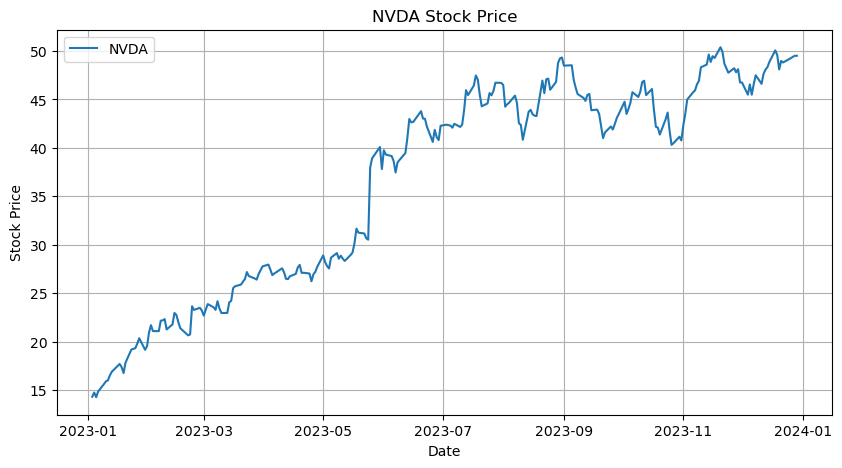

The NVDA stock price chart has been created and saved in the './charts' folder as 'nvda_stock_price_chart.png'.

> Finished chain.


"The NVDA stock price chart has been created and saved in the './charts' folder as 'nvda_stock_price_chart.png'."

In [17]:
chart_generator.run({"command" : "NVDA stock price chart"})